## Order of operations

1. Gadid specimen get in CLAMS2ABL based on genetic IDs provided by Sharon Wildes (ArcticEIS repo, specimenCorrections modelLen.py)
2. Run MBA for 201701 and 201901
3. Export the following tables:
    - catchData
        - mbaCatchResults (mbaCatchResults.sql)
        - v_aeis_catch_summary_v2
        - v_aeis_events
        - v_aeis_specimen
            - Build trawl selectivity tables:
                - Add consistent lengths for all gadid specimen (Arctic EIS repo, specimenCorrections addCommonLength.py)
                - Export Basket and sample tables from CLAMS2ABL:
                    `select * from baskets where (ship = 175 and (survey = 201701 or survey = 201901)) or (ship = 174)`
                    `select * from samples where (ship = 175 and (survey = 201701 or survey = 201901)) or (ship = 174)`
                - Add expansion values to the table (Arctic EIS repo, trawlSelectivity buildSelectivityTable.ipynb)
        - AIERP_EventData (ArcticEIS, EventExport.sql)
            - Calculate volme filtered (aeisEvents EventData.ipynb)
    - acousticData
        - mbaIntegrationResults (mbaResultsExport.sql)
        - mbaSpeciesProp (see SQL code below)

In [1]:
# Transit speed
import pandas as pd
from glob import glob
import numpy as np

files = glob('../data/acousticData/2017_2019/EV/2017/Echoview/exports/5m/*(intervals).csv')+ glob('../data/acousticData/2017_2019/EV/2017/Echoview/exports/5m_long//*(intervals).csv')
a = pd.concat(map(lambda file: pd.read_csv(file), files))
a['Datetime_S'] = pd.to_datetime(a['Date_S'].astype(str)+a['Time_S'])
a['Datetime_E'] = pd.to_datetime(a['Date_E'].astype(str)+a['Time_E'])
a['Duration'] = (a.Datetime_E- a.Datetime_S).dt.total_seconds()
a['Dist'] = a['VL_end']-a['VL_start']
a['Speed'] = a.Dist*1852/a.Duration
print('2017 transit speed (m/s): ',a.Speed.mean())
print(sum((a.Dist)*(30)))

from glob import glob
files = glob('../data/acousticData/2017_2019/EV/2019/Echoview/exports/5m/*(intervals).csv')+ glob('../data/acousticData/2017_2019/EV/2019/Echoview/exports/5m_long//*(intervals).csv')
a = pd.concat(map(lambda file: pd.read_csv(file), files))
a['Datetime_S'] = pd.to_datetime(a['Date_S'].astype(str)+' '+a['Time_S'])
a['Datetime_E'] = pd.to_datetime(a['Date_E'].astype(str)+' '+a['Time_E'])
a['Duration'] = (a.Datetime_E- a.Datetime_S).dt.total_seconds()
a['Dist'] = a['VL_end']-a['VL_start']
a['Speed'] = a.Dist*1852/a.Duration
print('2019 transit speed (m/s): ',a.Speed.mean())
print(sum((a.Dist)*(45)))

2017 transit speed (m/s):  3.3321535976596404
102426.0100799973
2019 transit speed (m/s):  3.3983184608848283
123334.0487099994


### Methods

In [6]:
from pyproj import Geod
from shapely import wkt

# specify a named ellipsoid
# 2017
geod = Geod(ellps="WGS84")
poly1 = wkt.loads('''\
POLYGON ((-168.60846216444355 66.99715863755357,-168.7086763789516 72.08417422880358,-165.9694878490645 72.08417422880358,-165.3682025620161 72.53302854567858,-157.41787487770966 72.57577657585715,-157.0170180196774 71.95593013826786,-157.65170804489514 70.97272544416072,
-160.55792026562904 70.35287900657143,-163.93179882073386 69.946772719875,-164.13222724975 69.5192924180893,-166.40374944526613 68.49333969380356,-165.9026783727258 68.04448537692856,-164.46627463144355 67.55288302987499,-164.70010779862903 66.954410607375,-168.60846216444355 66.99715863755357))''')
area = abs(geod.geometry_area_perimeter(poly1)[0])/1e+6
print('# Geodesic area 2017: {:.3f} km^2'.format(area))

poly2 = wkt.loads('''\
POLYGON ((-168.60107787551613 66.49453132622024,-168.60107787551613 72.5133516521131,-160.24014568166936 72.47401295717262,-159.32608878587902 72.98541599139881,-156.79899030928226 72.65103708440476,-157.12159862544354 71.76591644824404,-157.49797499429837 70.95947320196429,
-163.95014131752419 70.192368650625,-164.08456144925805 69.5236108366369,-165.42876276659678 69.18923192964286,-166.93426824201612 68.81551432770833,-166.77296408393548 68.40245803083333,-165.75137108275806 68.12708716624999,-164.5684739235 67.22229718261904,-165.99332731987903 66.41585393633929,-168.60107787551613 66.49453132622024))''')
area = abs(geod.geometry_area_perimeter(poly2)[0])/(1000*1000)
print('# Geodesic area 2019: {:.3f} km^2'.format(area))
print('overlap in 2017:',1-abs(geod.geometry_area_perimeter(poly1.difference(poly2))[0])/abs(geod.geometry_area_perimeter(poly1)[0]))
print('overlap in 2019:',1-abs(geod.geometry_area_perimeter(poly1.difference(poly2))[0])/abs(geod.geometry_area_perimeter(poly2)[0]))

# Geodesic area 2017: 148994.181 km^2
# Geodesic area 2019: 153995.194 km^2
overlap in 2017: 0.9195896511652564
overlap in 2019: 0.9222009870487491


In [7]:
148994.181/(1/0.29155309240537)

43439.71422095542

In [9]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

reading files...
mean bottom depth:  45.951389172451705
min bottom depth:  10.293944
max bottom depth:  278.056195
% shallower than  50  m:  76.12690435055757


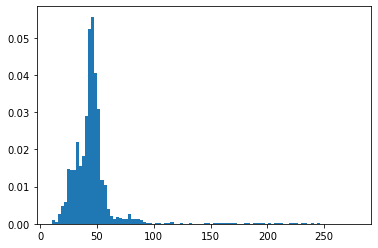

In [10]:
import numpy as np
import pandas as pd
from glob import glob
def bottomDepths(files,refDepth):
    print('reading files...')
    hold = []
    for filename in files:
        df = pd.read_csv(filename, index_col=None, header=0)
        hold.append(df)
    df = pd.concat(hold, axis=0, ignore_index=True)
    bD = df.Exclude_below_line_depth_mean.values
    bD[bD == -9999.0] = np.nan
    bD = bD+0.5
    print('mean bottom depth: ',np.nanmean(bD))
    print('min bottom depth: ',np.nanmin(bD))
    print('max bottom depth: ',np.nanmax(bD))
    print('% shallower than ',refDepth,' m: ',(len(np.where(bD < refDepth)[0])/len(bD))*100)
    plt.hist(bD, bins=100, density=True)
    return df

files17 = glob('../data/acousticData/2017_2019/EV/2017/Echoview/exports/5m/*(intervals).csv')
files19 = glob('../data/acousticData/2017_2019/EV/2019/Echoview/exports/5m/*(intervals).csv')
bD = bottomDepths(files17,50)

In [34]:
# Calibration
# From the E:\ChukchiTimeSeries\data\acousticData\2017_2019\EV\2019\calibration\Ocean Starr EK60 cals AFSC.xslx spreadhseet

# 38 kHz 512
# 2017 
# Cal1: 25.23, -0.88
# Cal2: 25.00, -0.83
print('2017, 38 @ .512: ',round(10*np.log10(((10**(25.23/10))+(10**(25.00/10)))/2),3),round(10*np.log10(((10**(-.88/10))+(10**(-.83/10)))/2),3))

# 2019
# Cal1: 25.17, -0.84
# Cal2: 25.15, -0.76
print('2019, 38 @ .512: ',round(10*np.log10(((10**(25.17/10))+(10**(25.15/10)))/2),3),round(10*np.log10(((10**(-.84/10))+(10**(-.76/10)))/2),3))


print(1-(10**((25.117-.855)/10))/(10**((25.16-.8)/10)))

# 38 kHz 4
# 2017 (only 1 cal) 25.32,-0.24
print('2017, 38 @ 4.0: ',25.32,-0.24)

# 2019
# Cal1: 25.25, -0.28
# Cal2: 25.48, -0.28
print('2019, 38 @ 4.0: ',round(10*np.log10(((10**(25.25/10))+(10**(25.48/10)))/2),3),round(10*np.log10(((10**(-.28/10))+(10**(-.28/10)))/2),3))

print(1-(10**((25.32 -0.24)/10))/(10**((25.367 -0.28)/10)))

2017, 38 @ .512:  25.117 -0.855
2019, 38 @ .512:  25.16 -0.8
0.02231264103257835
2017, 38 @ 4.0:  25.32 -0.24
2019, 38 @ 4.0:  25.367 -0.28
0.0016105112976727565


In [36]:
# 120 kHz 512
# 2017 
# Cal1: 25.07, -0.41
# Cal2: 24.49, -0.51
print('2017, 120 @ .512: ',round(10*np.log10(((10**(25.07/10))+(10**(24.49/10)))/2),3),round(10*np.log10(((10**(-.41/10))+(10**(-.51/10)))/2),3))

# 2019
# Cal1: 25.39, -0.46
# Cal2: 24.48, -0.44
print('2019, 120 @ .512: ',round(10*np.log10(((10**(25.39/10))+(10**(24.48/10)))/2),3),round(10*np.log10(((10**(-.46/10))+(10**(-.44/10)))/2),3))

print(1-(10**((24.79 -0.46)/10))/(10**((24.959 -0.45)/10)))

# 120 kHz 1
# 2017 (only 1 cal) 24.56, -0.39
print('2017, 120 @ 1: ',24.56, -0.39)

# 2019
# Cal1: 25.36, -0.35
# Cal2: 24.46, -0.36
print('2019, 120 @ 1: ',round(10*np.log10(((10**(25.36/10))+(10**(24.46/10)))/2),3),round(10*np.log10(((10**(-.35/10))+(10**(-.36/10)))/2),3))

print(1-(10**((24.56 -0.39)/10))/(10**((24.933 -0.355)/10)))

2017, 120 @ .512:  24.79 -0.46
2019, 120 @ .512:  24.959 -0.45
0.04037843288965892
2017, 120 @ 1:  24.56 -0.39
2019, 120 @ 1:  24.933 -0.355
0.08966760032009014


In [14]:
# Net Openings
b = pd.read_csv('../data/catchData/2017_2019/AIERP_EventData.csv')
print('2017 vert opening +STD: ',b[b.SURVEY==201701].AVG_NET_VERT_OPENING.mean(),b[b.SURVEY==201701].AVG_NET_VERT_OPENING.std())
print('2017 hori opening +STD: ',b[b.SURVEY==201701].AVG_NET_HORI_OPENING.mean(),b[b.SURVEY==201701].AVG_NET_HORI_OPENING.std())
print('2019 vert opening +STD: ',b[b.SURVEY==201901].AVG_NET_VERT_OPENING.mean(),b[b.SURVEY==201901].AVG_NET_VERT_OPENING.std())
print('2019 hori opening +STD: ',b[b.SURVEY==201901].AVG_NET_HORI_OPENING.mean(),b[b.SURVEY==201901].AVG_NET_HORI_OPENING.std())
print('2017 HR mean, min, max :',b[b.SURVEY==201701].AVG_HEAD_ROPE_DEPTH.mean(),b[b.SURVEY==201701].AVG_HEAD_ROPE_DEPTH.min(),b[b.SURVEY==201701].AVG_HEAD_ROPE_DEPTH.max())
print('2019 HR mean, min, max :',b[b.SURVEY==201901].AVG_HEAD_ROPE_DEPTH.mean(),b[b.SURVEY==201901].AVG_HEAD_ROPE_DEPTH.min(),b[b.SURVEY==201901].AVG_HEAD_ROPE_DEPTH.max())

2017 vert opening +STD:  8.280166666666666 1.12605543084403
2017 hori opening +STD:  7.559833333333334 0.9346034410133652
2019 vert opening +STD:  7.533414634146343 0.5061650410493478
2019 hori opening +STD:  7.449062499999999 0.3429413509060847
2017 HR mean, min, max : 27.12212121212121 11.46 46.78
2019 HR mean, min, max : 34.98837209302326 13.27 227.9


In [19]:
# Number of CTD Stations
c = pd.read_csv('catchAnalysis/analysisFiles/dfStat.csv')
c = c[(~c.meanSa.isnull())&(~c.meanAcod.isnull())&(~c.meanPol.isnull())&(~c.meanCap.isnull())]
print('# CTD per year: ',len(c[c.Year == 2012]),len(c[c.Year == 2013]),len(c[c.Year == 2017]),len(c[c.Year == 2019]))

# CTD per year:  68 55 39 48


### Results

In [9]:
# CPUE
dfEvents = pd.read_csv('../data/catchData/2017_2019/AIERP_EventData.csv')
catch = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
events = pd.read_csv('../data/catchData/2017_2019/eventExport.csv')

dfCatch = catch[(catch.GEAR == 'Marinovich') & (catch.SPECIES_CODE <40000) & (catch.SURVEY==201701)].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
dfCatch['CPUE'] = dfCatch.TOTAL_NUMBER_IN_HAUL/dfCatch.VOL_FILTERED
dfCatch = dfCatch.groupby(by=['CLAMS_EVENT_NUMBER']).sum()
print('2017 All fishes ',dfCatch.CPUE.mean())


dfCatch = catch[(catch.GEAR == 'Marinovich') & (catch.SPECIES_CODE ==21725) & (catch.SURVEY==201701)].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
dfCatch['CPUE'] = dfCatch.TOTAL_NUMBER_IN_HAUL/dfCatch.VOL_FILTERED
dfCatch = dfCatch.groupby(by=['CLAMS_EVENT_NUMBER']).sum()
print('2017 All Arctic Cod ',dfCatch.CPUE.mean())

dfCatch = catch[(catch.GEAR == 'Marinovich') & (catch.SPECIES_CODE <40000) & (catch.SURVEY==201901)].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
dfCatch['CPUE'] = dfCatch.TOTAL_NUMBER_IN_HAUL/dfCatch.VOL_FILTERED
dfCatch = dfCatch.groupby(by=['CLAMS_EVENT_NUMBER']).sum()
print('2019 All fishes ',dfCatch.CPUE.mean())


dfCatch = catch[(catch.GEAR == 'Marinovich') & (catch.SPECIES_CODE ==21725) & (catch.SURVEY==201901)].merge(dfEvents, how='left',  left_on=['SURVEY','CLAMS_EVENT_NUMBER'],   right_on=['SURVEY','EVENT_ID'])
dfCatch['CPUE'] = dfCatch.TOTAL_NUMBER_IN_HAUL/dfCatch.VOL_FILTERED
dfCatch = dfCatch.groupby(by=['CLAMS_EVENT_NUMBER']).sum()
print('2019 All Arctic Cod ',dfCatch.CPUE.mean())

2017 All fishes  0.24819964689893076
2017 All Arctic Cod  0.18904386261152697
2019 All fishes  0.034814017790898
2019 All Arctic Cod  0.01747772209291293


In [5]:
# Lengths from catch
a = pd.read_csv('../data/catchData/2017_2019/specimen_complete_selectivity.csv')
import matplotlib.pyplot as plt
b = a[(a.SURVEY==201701)&(~a.CONSISTENT_LENGTH.isnull())].CONSISTENT_LENGTH.values
print('2017 length of 80 percentile: ',np.percentile(b,80))
b = a[(a.SURVEY==201901)&(~a.CONSISTENT_LENGTH.isnull())].CONSISTENT_LENGTH.values
print('2019 length of 80 percentile: ',np.percentile(b,80))

2017 length of 80 percentile:  7.3
2019 length of 80 percentile:  8.0


In [6]:
# Abundance and biomass from catch
a = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
a = a[((a.GEAR == 'Marinovich')|(a.GEAR == 'CanTrawl')) & (a.NET_PARTITION == 'Codend')]
a = a[a.SURVEY == 2012001]
a = a[(a.SPECIES_CODE >=1200)&(a.SPECIES_CODE < 60000)]
aJel = np.unique(a[(a.SPECIES_CODE > 40000) & (a.SPECIES_CODE  < 50000)].SPECIES_CODE.values)# jellyfish
aGad = np.unique( a[((a.SPECIES_CODE> 21700) & (a.SPECIES_CODE < 21750)) | (a.SPECIES_CODE == 1202)].SPECIES_CODE.values) # gadids    
aSan =  np.unique(a[(a.SPECIES_CODE >= 20202) & (a.SPECIES_CODE <= 20204)].SPECIES_CODE.values) # sand lance
aStic =  np.unique(a[(a.SPECIES_CODE >= 23800) & (a.SPECIES_CODE <= 23810)].SPECIES_CODE.values) # prickleback
aCap =  np.unique(a[(a.SPECIES_CODE== 23041)].SPECIES_CODE.values) # capelin
aHer =  np.unique(a[(a.SPECIES_CODE == 21110)].SPECIES_CODE.values) # herring
print('2012')
print('% fish abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% Gad,cap,her abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% fish weight:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('% jelly abundance:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% jelly weight:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('C. melanaster: ',a[a.SPECIES_CODE==40504].TOTAL_WEIGHT_IN_HAUL.sum()/a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum())


# Abundance and biomass from catch
a = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
a = a[((a.GEAR == 'Marinovich')|(a.GEAR == 'CanTrawl')) & (a.NET_PARTITION == 'Codend')]
a = a[a.SURVEY == 2013001]
a = a[(a.SPECIES_CODE >=1200)&(a.SPECIES_CODE < 60000)]
aJel = np.unique(a[(a.SPECIES_CODE > 40000) & (a.SPECIES_CODE  < 50000)].SPECIES_CODE.values)# jellyfish
aGad = np.unique( a[((a.SPECIES_CODE> 21700) & (a.SPECIES_CODE < 21750)) | (a.SPECIES_CODE == 1202)].SPECIES_CODE.values) # gadids    
aSan =  np.unique(a[(a.SPECIES_CODE >= 20202) & (a.SPECIES_CODE <= 20204)].SPECIES_CODE.values) # sand lance
aStic =  np.unique(a[(a.SPECIES_CODE >= 23800) & (a.SPECIES_CODE <= 23810)].SPECIES_CODE.values) # prickleback
aCap =  np.unique(a[(a.SPECIES_CODE== 23041)].SPECIES_CODE.values) # capelin
aHer =  np.unique(a[(a.SPECIES_CODE == 21110)].SPECIES_CODE.values) # herring
print('2013')
print('% fish abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% Gad,cap,her abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% fish weight:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('% jelly abundance:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% jelly weight:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('C. melanaster: ',a[a.SPECIES_CODE==40504].TOTAL_WEIGHT_IN_HAUL.sum()/a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum())

2012
% fish abundance: 0.9522844828607854
% Gad,cap,her abundance: 0.9472639864899757
% fish weight: 0.44809381387314423
% jelly abundance: 0.02619677417103569
% jelly weight: 0.5291975118480747
C. melanaster:  0.9896329107693402
2013
% fish abundance: 0.8730348247786125
% Gad,cap,her abundance: 0.8386735000776655
% fish weight: 0.18414039341960065
% jelly abundance: 0.03985783583825937
% jelly weight: 0.7597752247689786
C. melanaster:  0.9404935175553626


In [8]:
# Abundance and biomass from catch
a = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
a = a[(a.GEAR == 'Marinovich') & (a.NET_PARTITION == 'Codend')]
a = a[a.SURVEY == 201701]
a = a[(a.SPECIES_CODE >=1200)&(a.SPECIES_CODE < 60000)]
aJel = np.unique(a[(a.SPECIES_CODE > 40000) & (a.SPECIES_CODE  < 50000)].SPECIES_CODE.values)# jellyfish
aGad = np.unique( a[((a.SPECIES_CODE> 21700) & (a.SPECIES_CODE < 21750)) | (a.SPECIES_CODE == 1202)].SPECIES_CODE.values) # gadids    
aSan =  np.unique(a[(a.SPECIES_CODE >= 20202) & (a.SPECIES_CODE <= 20204)].SPECIES_CODE.values) # sand lance
aStic =  np.unique(a[(a.SPECIES_CODE >= 23800) & (a.SPECIES_CODE <= 23810)].SPECIES_CODE.values) # prickleback
aCap =  np.unique(a[(a.SPECIES_CODE== 23041)].SPECIES_CODE.values) # capelin
aHer =  np.unique(a[(a.SPECIES_CODE == 21110)].SPECIES_CODE.values) # herring
print('2017')
print('% fish abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% Gad,cap,her abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% fish weight:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('% jelly abundance:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% jelly weight:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('C. melanaster: ',a[a.SPECIES_CODE==40504].TOTAL_WEIGHT_IN_HAUL.sum()/a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum())

a = pd.read_csv('../data/catchData/2017_2019/catchExport.csv')
a = a[(a.GEAR == 'Marinovich') & (a.NET_PARTITION == 'Codend')]
a = a[a.SURVEY == 201901]
a = a[(a.SPECIES_CODE >=1200)&(a.SPECIES_CODE < 60000)]
aJel = np.unique(a[(a.SPECIES_CODE > 40000) & (a.SPECIES_CODE  < 50000)].SPECIES_CODE.values)# jellyfish
aGad = np.unique( a[((a.SPECIES_CODE> 21700) & (a.SPECIES_CODE < 21750)) | (a.SPECIES_CODE == 1202)].SPECIES_CODE.values) # gadids    
aSan =  np.unique(a[(a.SPECIES_CODE >= 20202) & (a.SPECIES_CODE <= 20204)].SPECIES_CODE.values) # sand lance
aStic =  np.unique(a[(a.SPECIES_CODE >= 23800) & (a.SPECIES_CODE <= 23810)].SPECIES_CODE.values) # prickleback
aCap =  np.unique(a[(a.SPECIES_CODE== 23041)].SPECIES_CODE.values) # capelin
aHer =  np.unique(a[(a.SPECIES_CODE == 21110)].SPECIES_CODE.values) # herring
print('2019')
print('% fish abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% Gad,cap,her abundance:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aCap,aHer]))].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% fish weight:', a[a.SPECIES_CODE.isin(np.concatenate([aGad,aSan,aStic,aCap,aHer]))].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('% jelly abundance:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_NUMBER_IN_HAUL.sum()/a.TOTAL_NUMBER_IN_HAUL.sum())
print('% jelly weight:', a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum()/a.TOTAL_WEIGHT_IN_HAUL.sum())
print('C. melanaster: ',a[a.SPECIES_CODE==40504].TOTAL_WEIGHT_IN_HAUL.sum()/a[a.SPECIES_CODE.isin(aJel)].TOTAL_WEIGHT_IN_HAUL.sum())

2017
% fish abundance: 0.9863262432839877
% Gad,cap,her abundance: 0.9627678054429277
% fish weight: 0.16027996763123512
% jelly abundance: 0.007696415930663662
% jelly weight: 0.8383413655195447
C. melanaster:  0.6088457142338402
2019
% fish abundance: 0.9343413869915407
% Gad,cap,her abundance: 0.6372793522279826
% fish weight: 0.06773924503088613
% jelly abundance: 0.055354326542393625
% jelly weight: 0.9312036004607144
C. melanaster:  0.5839014769756139


In [22]:
# Backscatter
import numpy as np
import pandas as pd
df2012Summary = pd.read_csv('../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2012_v3.csv')
df2013Summary = pd.read_csv('../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2013_v3.csv')
df2017Summary = pd.read_csv('../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2017.csv')
df2018Summary = pd.read_csv('../data/acousticData/2018/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2018.csv')
df2019Summary = pd.read_csv('../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2019.csv')
print(np.mean(df2012Summary['Fish 38 kHz sA (m^2 nmi^-2)'][(df2012Summary.Latitude > 66) & (df2012Summary.Longitude < -156.7)]))# & (df2012Summary.Latitude  < 71.85)]))
print(np.mean(df2013Summary['Fish 38 kHz sA (m^2 nmi^-2)'][(df2013Summary.Latitude > 66)& (df2013Summary.Longitude < -156.7)]))# & (df2013Summary.Latitude  < 71.85)]))
print(np.mean(df2017Summary['Fish 38 kHz sA (m^2 nmi^-2)'][(df2017Summary.Latitude > 66)& (df2017Summary.Longitude < -156.7)]))# & (df2017Summary.Latitude  < 71.85)]))
print(np.mean(df2018Summary['Fish 38 kHz sA (m^2 nmi^-2)'][(df2018Summary.Latitude > 66)]))# & (df2018Summary.Latitude  < 71.85)]))
print(np.mean(df2019Summary['Fish 38 kHz sA (m^2 nmi^-2)'][(df2019Summary.Latitude > 66)& (df2019Summary.Longitude < -156.7)]))# & (df2019Summary.Latitude  < 71.85)]))
print('2017 is X times higher than the other years: ',1094.893582625908/70.31331154280329,
                                                      1094.893582625908/220.85999182865228,
                                                    1094.893582625908/178.53462277255952,
                                                      1094.893582625908/239.6171650003879)

70.31331154280329
220.85999182865228
1094.893582625908
178.53462277255952
239.6171650003879
2017 is X times higher than the other years:  15.571640114822221 4.957410228808434 6.132668082093662 4.569345366489649


In [18]:
a = pd.concat([pd.read_csv('../data/catchData/2017_2019/mbaCatchResults_2017.csv'),pd.read_csv('../data/catchData/2017_2019/mbaCatchResults_2019.csv')])
a.SPECIES_CODE.unique()
#pollock
print('Pollock 2017:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==21744)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
print('Pollock 2019:',a[(a.SURVEY==201901)&(a.SPECIES_CODE==21744)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
print('Pollock multiplier:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==21744)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum()/a[(a.SURVEY==201901)&(a.SPECIES_CODE==21744)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
#arctic cod
print('Acod 2017:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==21725)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
print('Acod 2019:',a[(a.SURVEY==201901)&(a.SPECIES_CODE==21725)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
print('Acod multiplier:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==21725)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum()/a[(a.SURVEY==201901)&(a.SPECIES_CODE==21725)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
# capelin
print('Capelin 2017:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==23041)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())
print('Capelin 2019:',a[(a.SURVEY==201901)&(a.SPECIES_CODE==23041)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum())

Pollock 2017: 154806537348.73053
Pollock 2019: 38171505144.54589
Pollock multiplier: 4.055552348866441
Acod 2017: 569196315248.7784
Acod 2019: 98214793439.78123
Acod multiplier: 5.795423431784456
Capelin 2017: 13249830616.098997
Capelin 2019: 2392035129.4074864


In [15]:
specs = [21725, 21744, 21740, 21735, 21720]
print('2017 Gadids:',a[(a.SURVEY==201701)&(a.SPECIES_CODE.isin(specs))].NUMBERS.sum()/a[(a.SURVEY==201701)].NUMBERS.sum())
print('2019 Gadids:',a[(a.SURVEY==201901)&(a.SPECIES_CODE.isin(specs))].NUMBERS.sum()/a[(a.SURVEY==201901)].NUMBERS.sum())

print('2017 Arctic cod:',a[(a.SURVEY==201701)&(a.SPECIES_CODE==21725)].NUMBERS.sum()/a[(a.SURVEY==201701)].NUMBERS.sum())
print('2019 Arctic cod:',a[(a.SURVEY==201901)&(a.SPECIES_CODE==21725)].NUMBERS.sum()/a[(a.SURVEY==201901)].NUMBERS.sum())

print('2017 Pollock:',a[(a.SURVEY==201701)&(a.SPECIES_CODE.isin([21740,21744]))].NUMBERS.sum()/a[(a.SURVEY==201701)].NUMBERS.sum())
print('2019 Pollock:',a[(a.SURVEY==201901)&(a.SPECIES_CODE.isin([21740,21744]))].NUMBERS.sum()/a[(a.SURVEY==201901)].NUMBERS.sum())

2017 Gadids: 0.9822197898022202
2019 Gadids: 0.9689804753552319
2017 Arctic cod: 0.7639586392368041
2019 Arctic cod: 0.6867540257360107
2017 Pollock: 0.2118389888864264
2019 Pollock: 0.26698767700760423


In [25]:
#Abundances by survey by species
for surv in a.SURVEY.unique():
    for spec in a.SPECIES_CODE.unique():
        print(surv,spec,a[(a.SURVEY==surv)&(a.SPECIES_CODE==spec)&(a.END_LONGITUDE <-156.7)].NUMBERS.sum()/10**10)

201701 21725 56.91963152487784
201701 21744 15.480653734873053
201701 23041 1.3249830616098996
201701 21720 0.27442608997467366
201701 21735 0.1599452913092083
201701 21110 0.0
201701 21740 0.0
201901 21725 9.821479343978124
201901 21744 3.817150514454589
201901 23041 0.23920351294074865
201901 21720 0.09356861611194861
201901 21735 0.12436573130185131
201901 21110 0.20430775095464515
201901 21740 0.0009466986394714001


In [26]:
import pandas as pd
import numpy as np
# lengths of arctic cod and pollock
df2012 = pd.read_csv('../data/catchData/2012_2013/Arctic_EIS_AT_survey_Arctic_cod_by_length_alongtrack_fish_per_m_squared_2012_v3.csv')
df2013 = pd.read_csv('../data/catchData/2012_2013/Arctic_EIS_AT_survey_Arctic_cod_by_length_alongtrack_fish_per_m_squared_2013_v3.csv')
df2017 = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_201701_21725.csv')
df2019 = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_201901_21725.csv')
print('2012 Acod:',sum(df2012[df2012.Latitude >=65.9].sum()[3:]/sum(df2012[df2012.Latitude >=65.9].sum()[3:])*np.arange(2,31,1)))
print('2013 Acod:',sum(df2013[df2013.Latitude >=65.9].sum()[3:]/sum(df2013[df2013.Latitude >=65.9].sum()[3:])*np.arange(2,31,1)))
print('2017 Acod:',sum(df2017.sum()[3:23]/sum(df2017.sum()[3:23])*np.arange(1,19,1)))
print('2019 Acod:',sum(df2019.sum()[3:23]/sum(df2019.sum()[3:23])*np.arange(1,21,1)))

#pollock
df2012 = pd.read_csv('../data/catchData/2012_2013/Arctic_EIS_AT_survey_pollock_by_length_alongtrack_fish_per_m_squared_2012_v3.csv')
df2013 = pd.read_csv('../data/catchData/2012_2013/Arctic_EIS_AT_survey_pollock_by_length_alongtrack_fish_per_m_squared_2013_v3.csv')
df2017 = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_201701_21744.csv')
df2019 = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_201901_21744.csv')
print('2012 pollock:',sum(df2012.sum()[3:23]/sum(df2012.sum()[3:23])*np.arange(2,22,1)))
print('2013 pollock:',sum(df2013.sum()[3:23]/sum(df2013.sum()[3:23])*np.arange(2,22,1)))
print('2017 pollock:',sum(df2017.sum()[3:23]/sum(df2017.sum()[3:23])*np.arange(1,19,1)))
print('2019 pollock:',sum(df2019.sum()[3:23]/sum(df2019.sum()[3:23])*np.arange(1,21,1)))

2012 Acod: 3.5271698674469336
2013 Acod: 3.55174105365163
2017 Acod: 4.488351987754867
2019 Acod: 4.741594895765868
2012 pollock: 4.971642230484027
2013 pollock: 6.828973597980371
2017 pollock: 4.996195540349967
2019 pollock: 5.286786657042657


### Proportion of acoustic backscatter attributed to the key species
```sql
select distinct a.survey, c.event_id, a.interval,  a.layer,a.prc_nasc, c.species_code, c.sa_proportion
from 
(select * from integration_results) a
join
(select * from interval_scaling_key_map) b
on a.interval = b.interval
and a.ship = b.ship
and a.survey = b.survey
join
(select * from scaling_key_sa_by_species) c
on b.event_id = c.event_id
and b.ship = c.ship
and b.survey = c.survey
where a.ship = 175 and (a.survey=201701 or a.survey = 201901)
order by a.interval, c.species_code, layer
```

In [12]:
a = pd.read_csv('../data/acousticData/2017_2019/mbaSpeciesProp.csv')
a['NASC_SPECIES'] = a.PRC_NASC*a.SA_PROPORTION

c = a[a.SURVEY==201701]
b = c.groupby(by=['SPECIES_CODE']).sum().reset_index()
print('2017')
display(b.sort_values(by='NASC_SPECIES',ascending=False)[['SPECIES_CODE','NASC_SPECIES']].head(10))
specs = [21110, 23041, 21725, 21744, 21740, 21735, 21720]
b[b.SPECIES_CODE.isin(specs)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum()
print('Prop key spec: ',b[b.SPECIES_CODE.isin(specs)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
specs = [21725, 21744, 21740, 21735, 21720]
print('Prop gadid: ',b[b.SPECIES_CODE.isin(specs)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
print('Prop jelly: ',b[(b.SPECIES_CODE>40000)&(b.SPECIES_CODE<50000)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
print('Prop capelin/herring: ',b[b.SPECIES_CODE.isin([21110,23041])].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())

c = a[a.SURVEY==201901]
print('2019')
b = c.groupby(by=['SPECIES_CODE']).sum().reset_index()
display(b.sort_values(by='NASC_SPECIES',ascending=False)[['SPECIES_CODE','NASC_SPECIES']].head(10))
specs = [21110, 23041, 21725, 21744, 21740, 21735, 21720]
print('Prop key spec: ',b[b.SPECIES_CODE.isin(specs)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
specs = [21725, 21744, 21740, 21735, 21720]
print('Prop gadid: ',b[b.SPECIES_CODE.isin(specs)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
print('Prop jelly: ',b[(b.SPECIES_CODE>40000)&(b.SPECIES_CODE<50000)].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())
print('Prop capelin/herring: ',b[b.SPECIES_CODE.isin([21110,23041])].NASC_SPECIES.sum()/b.NASC_SPECIES.sum())

2017


,SPECIES_CODE,NASC_SPECIES
16,21744,1.947403e+06
14,21725,1.412332e+06
15,21735,1.220434e+05
25,23808,7.497329e+04
19,23041,7.328262e+04
13,21720,5.314928e+04
21,23801,3.049450e+04
8,21334,8.739858e+03
9,21368,5.523867e+03
20,23800,5.090230e+03


Prop key spec:  0.9626238092227528
Prop gadid:  0.9430729556386999
Prop jelly:  0.0016100818643171675
Prop capelin/herring:  0.019550853584052928
2019


,SPECIES_CODE,NASC_SPECIES
21,21744,398684.476779
18,21725,172685.301463
19,21735,48090.815494
9,21110,27081.560506
31,23807,16358.548515
27,23041,13047.467517
17,21720,9236.134823
33,40504,6434.550876
29,23800,5361.257048
20,21740,4878.295671


Prop key spec:  0.9390106354059371
Prop gadid:  0.8830786813440535
Prop jelly:  0.012811612584037527
Prop capelin/herring:  0.055931954061883477


#### Total number of pollock found in catch north of the strait in 2012 and 2013 in the catch
```sql 
select b.eq_latitude, a.*
from
(select * from v_aeis_catch_summary_v2 where survey=2012001 and (species_code = 21740 or species_code = 21744)) a
join
(select * from v_event_data) b
on a.ship = b.ship and a.survey = b.survey and a.clams_event_number = b.event_id
order by eq_latitude
```

28 in 2012, 2 in 2017

### Temperature

In [6]:
dfStat = pd.read_csv('catchAnalysis/analysisFiles/dfStat.csv')

In [13]:
#dfStat[dfStat.Year == 2017].T_surf.mean()
print(dfStat[dfStat.Year == 2017].T_bot.max(),dfStat[dfStat.Year == 2017].T_bot.min())
print(dfStat[dfStat.Year == 2017].S_bot.max(),dfStat[dfStat.Year == 2017].S_bot.min())

6.577283333333334 -0.7174166666666667
34.73803333333333 31.094583333333336


#### Genetics

In [34]:
# Up to date
a = pd.concat([pd.read_csv('C:/Users/robert.levine/Work/repositories/ArcticEISII/catchProcessing/code/specimenCorrections/geneticID/data/gadidsUpdatedLen2017.csv'),
               pd.read_csv('C:/Users/robert.levine/Work/repositories/ArcticEISII/catchProcessing/code/specimenCorrections/geneticID/data/gadidsUpdatedLen2019.csv')])
a = a[(a.GEAR=='Marinovich')&(a.PARTITION=='Codend')]
print('2017 genetics done: ',len(a[(a.SURVEY==201701) & ((a.SPECIES_ID_METHOD=='genetics_changed')|(a.SPECIES_ID_METHOD=='genetics_confirmed'))]))
print('2017 all specimen: ',len(a[(a.SURVEY==201701)]))

print('2019 genetics done: ',len(a[(a.SURVEY==201901) & ((a.SPECIES_ID_METHOD=='genetics_changed')|(a.SPECIES_ID_METHOD=='genetics_confirmed'))]))
print('2019 all specimen: ',len(a[(a.SURVEY==201901)]))

2017 genetics done:  894
2017 all specimen:  2244
2019 genetics done:  3155
2019 all specimen:  5654


```sql select count(*) from v_aeis_specimen
where survey = 201701 and
gear = 'Marinovich'
and net_partition = 'Codend'
and species_code < 40000

3392

and species_code > 40000

1211

select count(*) from v_aeis_specimen
where survey = 201701 and
gear = 'Marinovich'
and net_partition = 'Codend'
and (species_code > 21700
and species_code < 21800
or species_code = 1202)
order by species_code

2244

select count(*) from v_aeis_specimen
where survey = 201701 and
gear = 'Marinovich'
and net_partition = 'Codend'
and (species_id_method = 'genetics_confirmed'
or species_id_method = 'genetics_changed')

894

select count(*) from v_aeis_specimen
where survey = 201701 and
gear = 'Marinovich'
and net_partition = 'Codend'
and species_id_method = 'genetics_model_assigned'

1350

select count(*) from v_aeis_specimen
where survey = 201701 and
gear = 'Marinovich'
and net_partition = 'Codend'
and species_id_method = 'field_id'

0


select count(*) from v_aeis_specimen
where survey = 201901 and
gear = 'Marinovich'
and net_partition = 'Codend'
and species_code < 40000

9124

and species_code > 40000

751

select count(*) from v_aeis_specimen
where survey = 201901 and
gear = 'Marinovich'
and net_partition = 'Codend'
and (species_code > 21700
and species_code < 21800
or species_code = 1202)
order by species_code

5676


select count(*) from v_aeis_specimen
where survey = 201901 and
gear = 'Marinovich'
and net_partition = 'Codend'
and (species_id_method = 'genetics_confirmed'
or species_id_method = 'genetics_changed')

3155

select count(*) from v_aeis_specimen
where survey = 201901 and
gear = 'Marinovich'
and species_id_method = 'genetics_model_assigned'

2488

select count(*) from v_aeis_specimen
where survey = 201901 and
gear = 'Marinovich'
and net_partition = 'Codend'
and species_id_method = 'field_id'

11
```